# Experiments

In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import os
from data.load_data import load_monk, load_MLCup
from src.MetricFunctions import get_metric_instance
from src.MLP import MLP
from src.GridSearch import GridSearch, RandomGridsearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from src.EarlyStopping import EarlyStopping
from src.BestModelSearch import BestModelSearch

## Task 1: Regression

Preparation: Loading MLCup Dataset

In [2]:
path = os.getcwd()
file_train = '/data/ML-CUP22-TR.csv'
file_test = '/data/ML-CUP22-TS.csv'

labels_train = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','y1','y2']
labels_test = ['x1','x2','x3','x4','x5','x6','x7','x8','x9']

X_train, y_train = load_MLCup(path + file_train, labels_train)
X_test = load_MLCup(path + file_test, labels_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)



(1485, 9)
(1485, 2)
(529, 9)


2.0548248334219843
2.0200779984859394
3.246649412096712
33.56653062343311


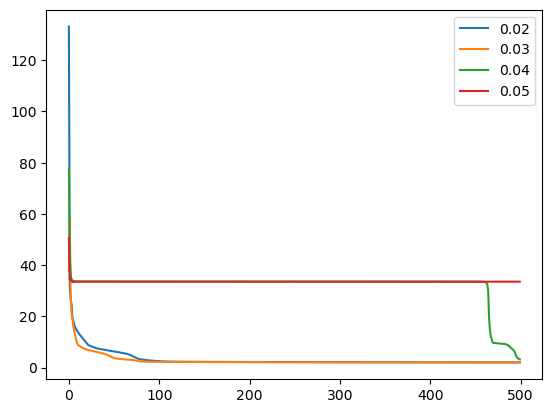

In [11]:
fig, ax = plt.subplots()
for step in [0.02,0.03,0.04,0.05]:
    mlp = MLP([60,40,20], 9, 2, task = "regression", activation_function = 'sigm')
    mlp.fit(X_train, y_train, n_epochs = 500, batch_size = 256, momentum = 0.8, Nesterov = False, step = step, patience = 1000)
    ax.plot(mlp.validation_curve, label = str(step))
    print(mlp.validation_curve[499])
ax.legend()

2.290366618076458
3.235713482117221


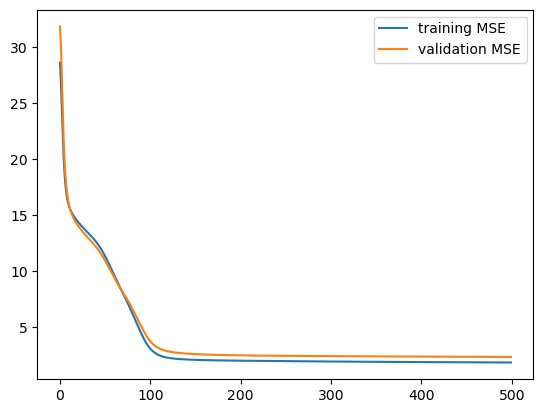

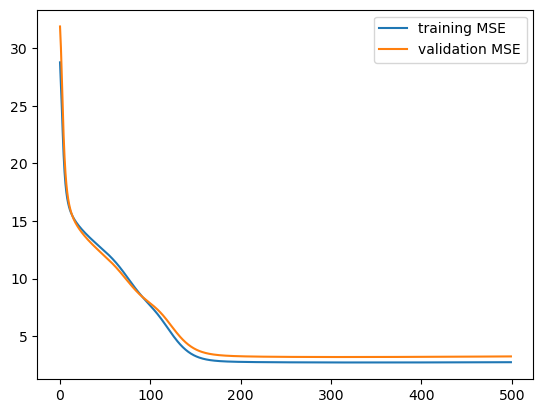

In [7]:
for alpha_l2 in [0,0.05]:
    mlp = MLP([60,20], 9, 2, task = "regression", activation_function = 'sigm')
    mlp.fit(X_train, y_train, n_epochs = 500, batch_size = 256, step = 0.02, 
            momentum = 0.8, Nesterov = True, patience = 1000, regularization = "l2", alpha_l2=alpha_l2)
    fig, ax = plt.subplots()
    ax.plot(mlp.learning_curve, label = "training MSE")
    ax.plot(mlp.validation_curve, label = "validation MSE")
    ax.legend()
    print(mlp.validation_curve[499])
    

## Task 2: Classification

### Preparation: Loading Monk Datasets

In [3]:
path = os.getcwd()
file_train = '/data/monks-1.train'

labels = ['class','x1','x2','x3','x4','x5','x6']

TR_sets = [[]] 
TS_sets = [[]] 
for i in range(1,4):
    TR_sets.append(load_monk(path + f'/data/monks-{i}.train', labels))
    TS_sets.append(load_monk(path + f'/data/monks-{i}.test', labels))


TypeError: load_monk() missing 1 required positional argument: 'labels'

### Experiment 2.1 - Sigmoid Activation

**************************************
Monk Dataset 1

Accuracy on test set 0: 0.9375

**************************************
Monk Dataset 2

Accuracy on test set 1: 0.9444444444444444

**************************************
Monk Dataset 3

Accuracy on test set 2: 0.9398148148148148

**************************************
Monk Dataset 3

Accuracy on test set 3: 0.9398148148148148

[[array([0.25439942, 0.25380569, 0.25312999, ..., 0.04115919, 0.04099456,
       0.04083045]), array([0.51612903, 0.52419355, 0.52419355, ..., 0.98387097, 0.98387097,
       0.98387097])], [array([0.25274025, 0.25232594, 0.25185682, ..., 0.06968342, 0.06940188,
       0.06912123]), array([0.50462963, 0.50925926, 0.50462963, ..., 0.93518519, 0.9375    ,
       0.9375    ])]]


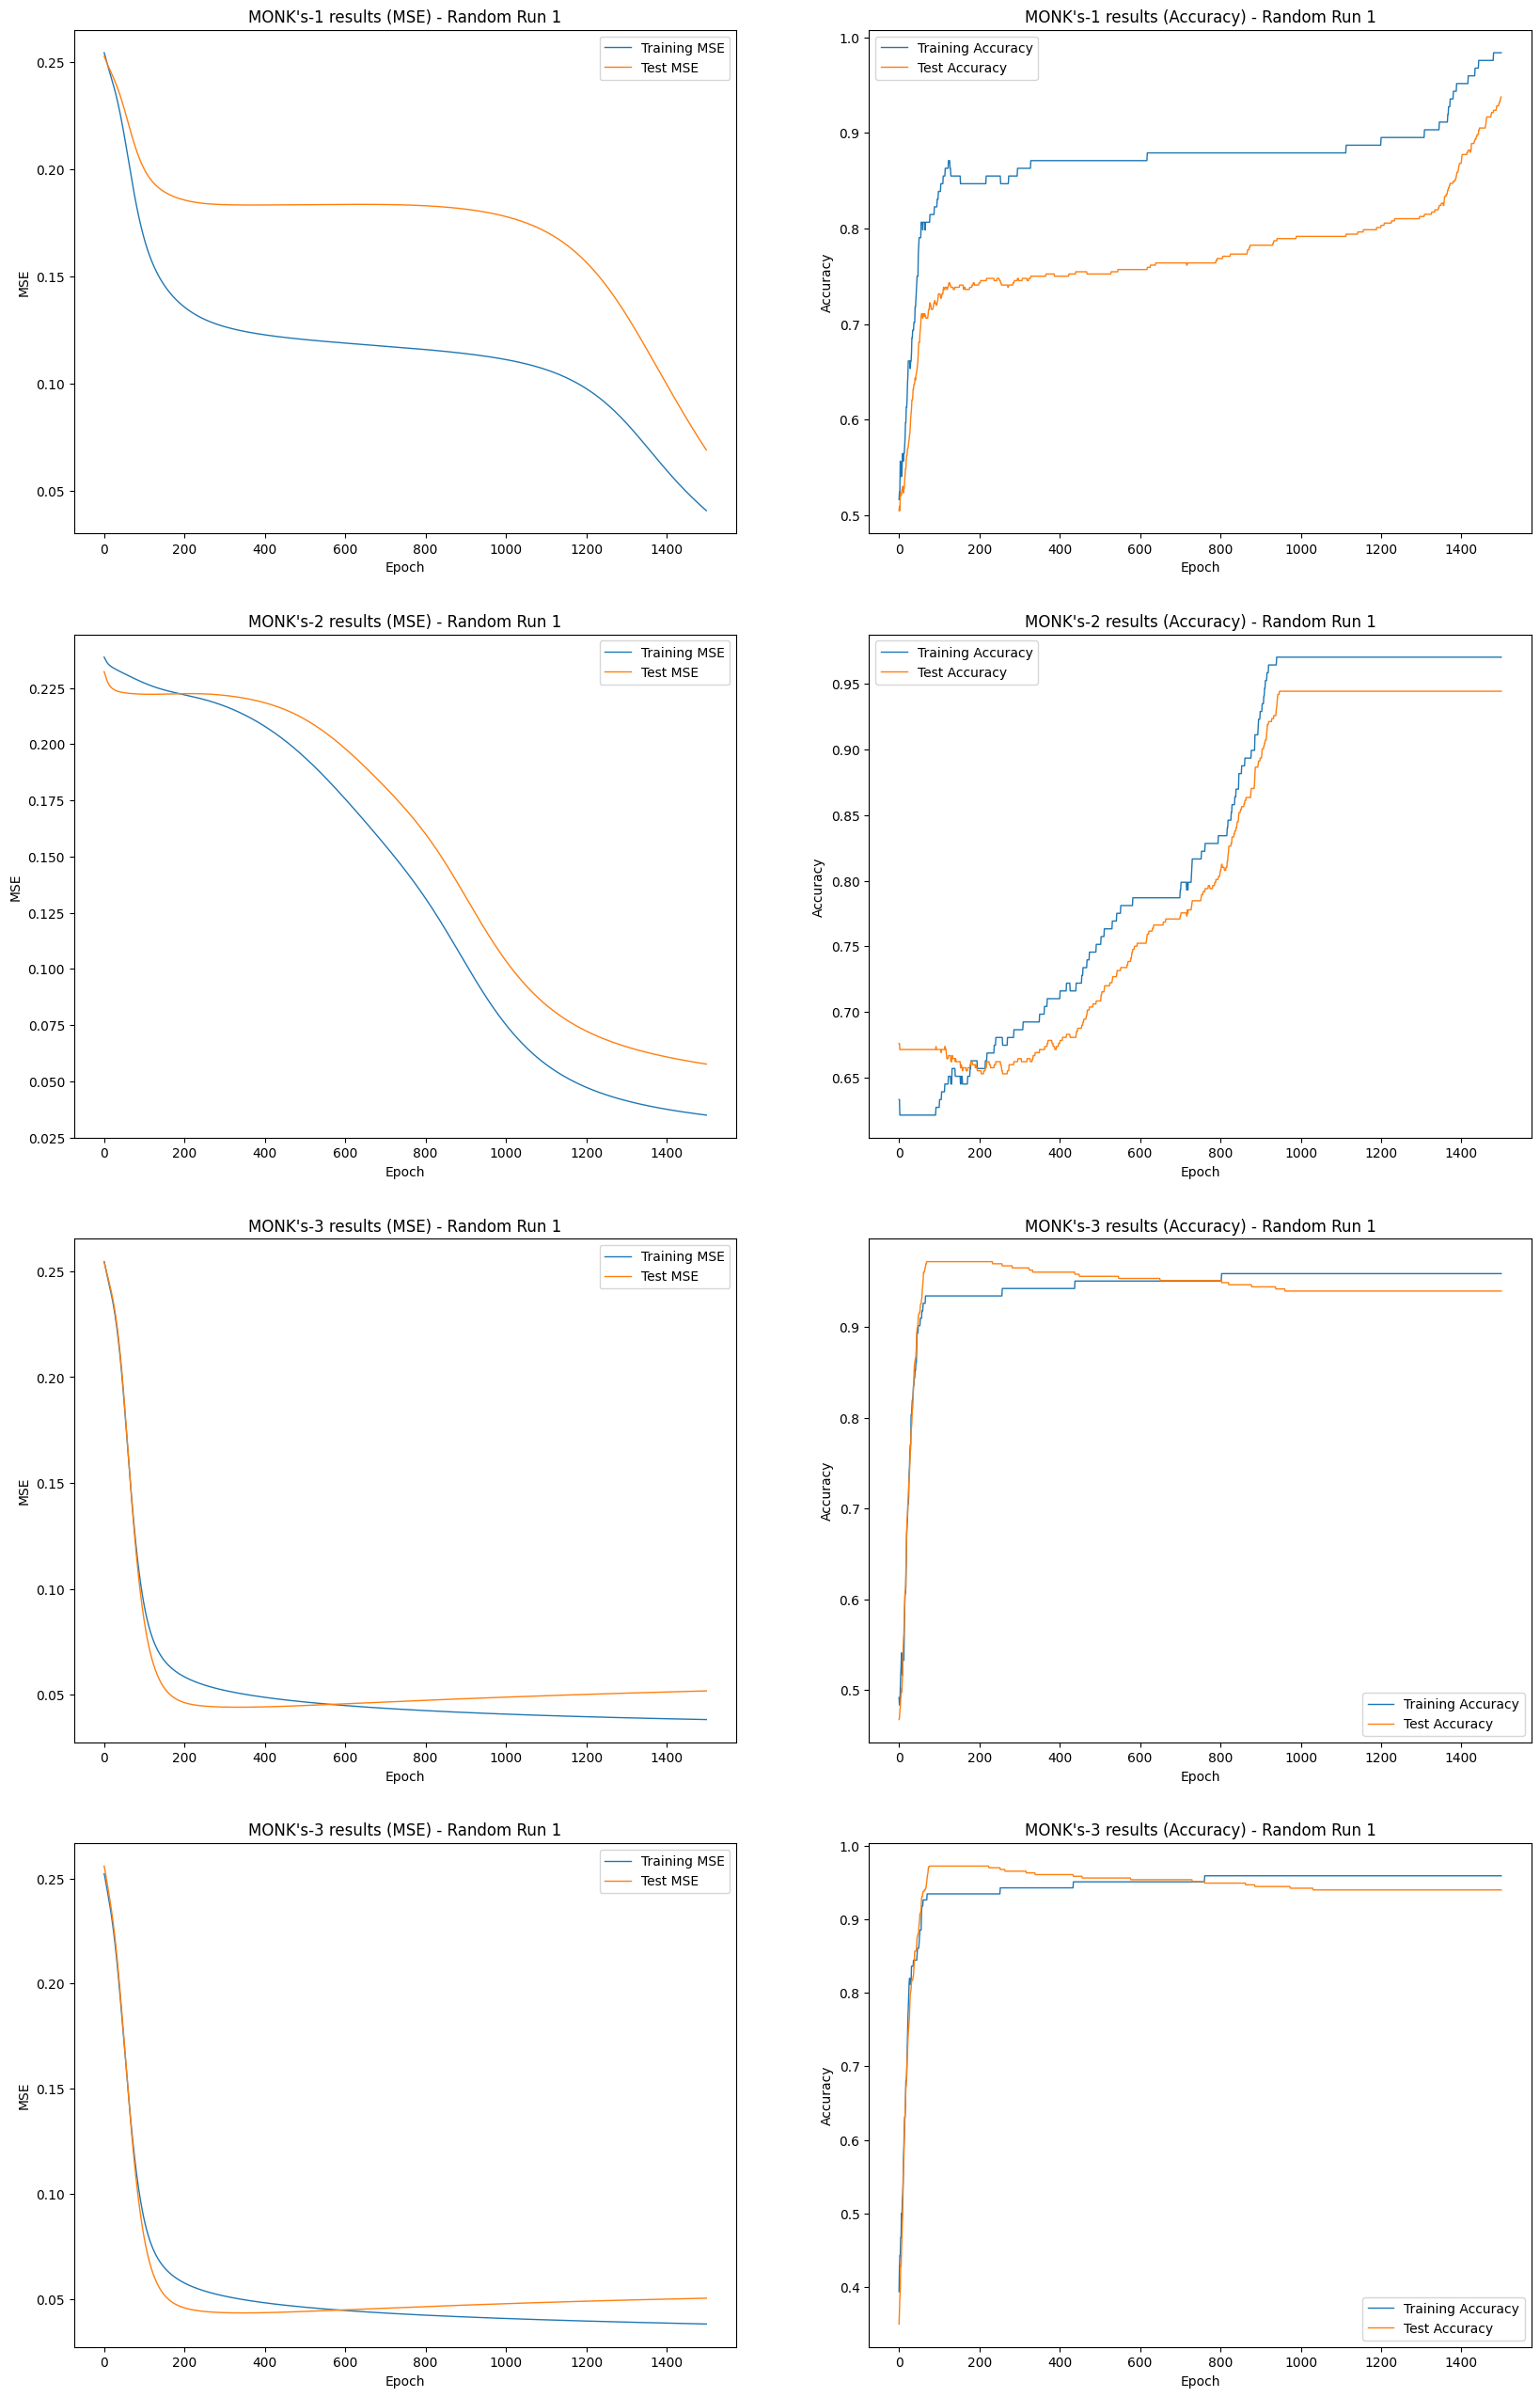

In [7]:
curves = []
params = {
    "n_epochs" : 1500, 
    "error" : "mse", 
    "verbose" : False,
    "step" : 0.3, 
    "momentum" : 0.5, 
    "weights_scale" : 0.01,
    "weights_initialization" : 'xavier',
    "early_stopping" : False,
    "eval_metric" : 'mse'
    }


def name(i):
    if i in (0,1,2):
        return i + 1
    else:
        return i

for i in range(0,4):

    print("**************************************")
    print(f"Monk Dataset {name(i)}")
    input_size = TR_sets[name(i)][0][0].shape[0]
    n_samples = TR_sets[name(i)][0].shape[0]
    params["batch_size"] = n_samples
    
    mlp = MLP([4], input_size = input_size, output_size = 1, task = "classification", activation_function = 'tanh')

    # Curves with MSE/Accuracy
    if i < 4:
        # All without regularization
        params["regularization"] = 'no'
        mlp.fit(X = TR_sets[name(i)][0], y_true = TR_sets[name(i)][1], X_test = TS_sets[name(i)][0], y_test =  TS_sets[name(i)][1], **params)
    else:
        # Monk 3 with regularization
        params["regularization"] = 'l2'
        params["alpha_l2"] = 10
        mlp.fit(X = TR_sets[name(i)][0], y_true = TR_sets[name(i)][1], X_test = TS_sets[name(i)][0], y_test =  TS_sets[name(i)][1], **params)
      
    curves.append([[mlp.learning_curve, mlp.learning_accuracy_curve], [mlp.validation_curve, mlp.test_accuracy_curve]])
    
    print()
    print(f"Accuracy on test set {i}: {mlp.evaluate_model(TS_sets[name(i)][0], TS_sets[name(i)][1], metric = 'accuracy')}")
    print()



# Plot the learning curves
figure, axis = plt.subplots(4, 2, figsize = (20, 32))

for j in range(0,4):

    # Plot MSE training and validation curves
    axis[j, 0].plot(range(0, len(curves[j][0][0]), 1), curves[j][0][0],\
        linewidth = 1, label = 'Training MSE')
    axis[j, 0].plot(range(0, len(curves[j][1][0]), 1), curves[j][1][0],\
        linewidth = 1, label = 'Test MSE')
    axis[j, 0].set_title(f"MONK's-{name(j)} results (MSE) - Random Run 1")
    axis[j, 0].set_xlabel('Epoch') 
    axis[j, 0].set_ylabel('MSE')  
    axis[j, 0].legend()


    # Plot Accuracy training and validation curves
    axis[j, 1].plot(range(0, len(curves[j][0][1]), 1), curves[j][0][1],\
        linewidth = 1, label = 'Training Accuracy')
    axis[j, 1].plot(range(0, len(curves[j][1][1]), 1), curves[j][1][1],\
        linewidth = 1, label = 'Test Accuracy')
    axis[j, 1].set_title(f"MONK's-{name(j)} results (Accuracy) - Random Run 1")
    axis[j, 1].set_xlabel('Epoch') 
    axis[j, 1].set_ylabel('Accuracy')  
    axis[j, 1].legend()

plt.show()


In [ ]:
"""
fig, ax = plt.subplots()
learning_curves = []

for i in range(1,4):
    
    n_samples = TR_sets[i][0].shape[0]
    
    grid_parameters = {'n_epochs': [500, 1000],
        'batch_size': [n_samples], 
        'step': [1e-4, 1e-3, 1e-2, 1e-1],
        'momentum' : [0.5, 0.75],
        'error' : ["mse"],
        'verbose' : [False],
        'Nesterov' : [True, False]
        'regularization' : ['l2'],
        'alpha_l1' : [0],
        'alpha_l2' : [1e-1, 1e-2, 1e-3, 1e-57],
        }

    print("**************************************")
    print(f"Monk Dataset {i}")

    input_size = TR_sets[i][0][0].shape[0]
    mlp = MLP([4], input_size = input_size, output_size = 1, task = "classification", activation_function = 'tanh')

    model_search = BestModelSearch(mlp)
    model_search.fit(X_train = TR_sets[i][0], y_train = TR_sets[i][1], X_test = TS_sets[i][0], y_test = TS_sets[i][1], parameters_grid = grid_parameters, verbose = False, parallel = False)

    best_model = model_search.best_model
    learning_curves.append(best_model.learning_curve)

    print()
    print(f"Accuracy on test set {i}: {best_model.evaluate_model(TS_sets[i][0], TS_sets[i][1])}")
    print("Reached with parameters: ", model_search.get_best_parameters())
    print()

j = 1
for learning_curve in learning_curves:
    ax.plot(range(0, len(learning_curve), 1), learning_curve, linewidth = 1, label =f'Monk Dataset {j}')
    j += 1


ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title("Learning curves on monk datasets")

"""

'\nfig, ax = plt.subplots()\nlearning_curves = []\n\nfor i in range(1,4):\n    \n    n_samples = TR_sets[i][0].shape[0]\n    \n    grid_parameters = {\'n_epochs\': [500, 1000],\n        \'batch_size\': [n_samples], \n        \'step\': [1e-4, 1e-3, 1e-2, 1e-1],\n        \'momentum\' : [0.5, 0.75],\n        \'error\' : ["mse"],\n        \'verbose\' : [False],\n        \'Nesterov\' : [True, False]\n        \'regularization\' : [\'l2\'],\n        \'alpha_l1\' : [0],\n        \'alpha_l2\' : [1e-1, 1e-2, 1e-3, 1e-57],\n        }\n\n    print("**************************************")\n    print(f"Monk Dataset {i}")\n\n    input_size = TR_sets[i][0][0].shape[0]\n    mlp = MLP([4], input_size = input_size, output_size = 1, task = "classification", activation_function = \'tanh\')\n\n    model_search = BestModelSearch(mlp)\n    model_search.fit(X_train = TR_sets[i][0], y_train = TR_sets[i][1], X_test = TS_sets[i][0], y_test = TS_sets[i][1], parameters_grid = grid_parameters, verbose = False, para

In [11]:
import numpy as np
np.random.random()

0.4266044965132104

In [14]:
np.random.random()

0.5488135039273248

In [16]:
np.random.seed(0)

In [17]:
np.random.random()

0.5488135039273248